In [49]:
!pip install jovian --upgrade --quiet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [50]:
# Uncomment and run the commands below if imports fail
!conda install numpy pytorch torchvision cpuonly -c pytorch -y
!pip install matplotlib --upgrade --quiet
!pip install pandas --upgrade --quiet
!pip install seaborn --upgrade --quiet
!pip install jovian --upgrade --quiet

Solving environment: done

# All requested packages already installed.

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [51]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split
%matplotlib inline

In [52]:
project_name='forest-fires-regression-model' # will be used by jovian.commit

In [53]:
df_raw = pd.read_csv('../input/forestfires/forestfires.csv')
df_raw.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [54]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [55]:
df = df_raw.drop(['X','Y','month','day','area','DMC','DC'], axis=1)
df.head()

,FFMC,ISI,temp,RH,wind,rain
0,86.2,5.1,8.2,51,6.7,0.0
1,90.6,6.7,18.0,33,0.9,0.0
2,90.6,6.7,14.6,33,1.3,0.0
3,91.7,9.0,8.3,97,4.0,0.2
4,89.3,9.6,11.4,99,1.8,0.0


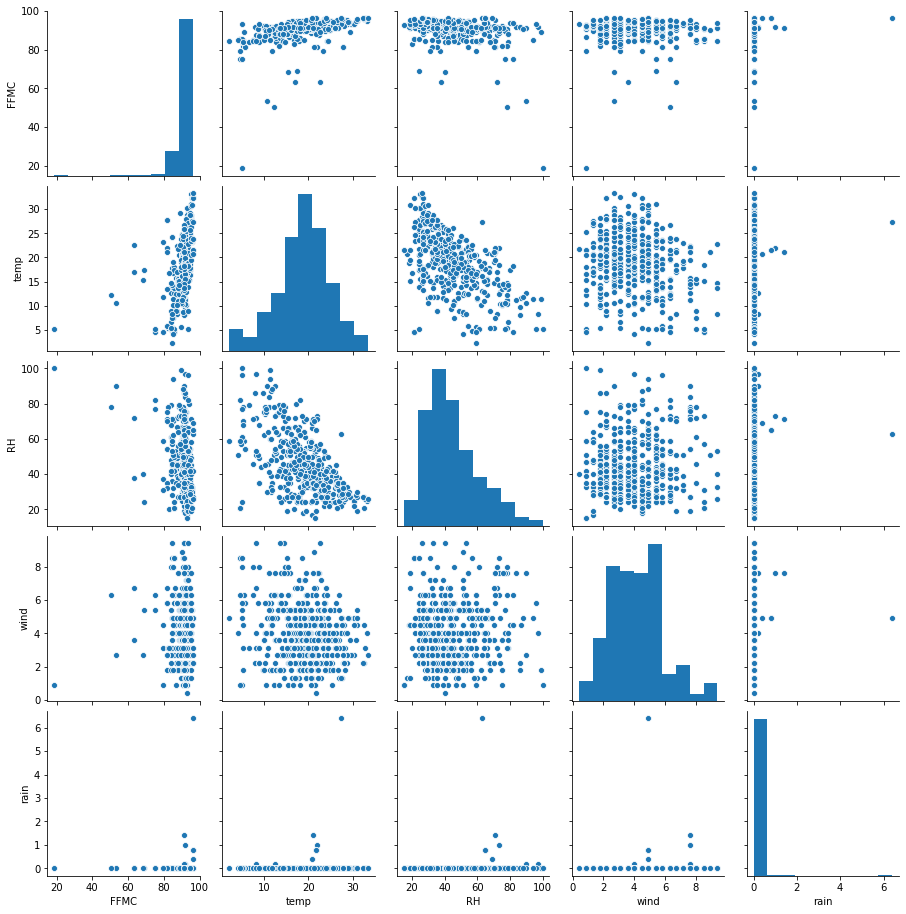

In [56]:
sns.pairplot(df[['FFMC', 'temp', 'RH', 'wind', 'rain']])
plt.show()

In [57]:
num_rows = df.shape[0]
num_cols = df.shape[1]


In [58]:
input_cols = ['FFMC','temp','RH','wind','rain']
output_cols = ['ISI']

In [59]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "imakshit/forest-fires-regression-model" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/imakshit/forest-fires-regression-model


'https://jovian.ml/imakshit/forest-fires-regression-model'

In [60]:
def dataframe_to_arrays(dataframe):
    dataframe1 = dataframe.copy(deep=True)
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

In [61]:
inputs_array, targets_array = dataframe_to_arrays(df)

In [62]:
inputs = torch.from_numpy(inputs_array).float()
targets = torch.from_numpy(targets_array).float()

In [63]:
dataset = TensorDataset(inputs, targets)

In [64]:
val_percent = 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

train_ds, val_ds = random_split(dataset, [train_size,val_size])

In [65]:
batch_size = 10

In [66]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [67]:
input_size = len(input_cols)
output_size = len(output_cols)

In [68]:
class FFModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out, targets)
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 10th epoch
        if (epoch+1) % 10 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [69]:
ffmodel = FFModel()

In [70]:
list(ffmodel.parameters())

[Parameter containing:
 tensor([[-0.1787,  0.3364, -0.0110,  0.0447,  0.1001]], requires_grad=True),
 Parameter containing:
 tensor([0.0420], requires_grad=True)]

In [71]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "imakshit/forest-fires-regression-model" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/imakshit/forest-fires-regression-model


'https://jovian.ml/imakshit/forest-fires-regression-model'

In [72]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [73]:
result = evaluate(ffmodel, val_loader)
print(result)

{'val_loss': 19.60767364501953}


In [74]:
epochs = 100
lr = 1e-5
history1 = fit(epochs, lr, ffmodel, train_loader, val_loader)

Epoch [10], val_loss: 2.7880
Epoch [20], val_loss: 2.7999
Epoch [30], val_loss: 2.7989
Epoch [40], val_loss: 2.8048
Epoch [50], val_loss: 2.8267
Epoch [60], val_loss: 2.8219
Epoch [70], val_loss: 2.8281
Epoch [80], val_loss: 2.8400
Epoch [90], val_loss: 2.8560
Epoch [100], val_loss: 2.8628


In [75]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [76]:
from random import sample

for i in sample(range(0,len(val_ds)),5):
    input, target = val_ds[i]
    predict_single(input, target, ffmodel)
    print()

Input: tensor([91.5000, 20.6000, 37.0000,  1.8000,  0.0000])
Target: tensor([7.5000])
Prediction: tensor([8.6072])

Input: tensor([87.6000, 11.0000, 46.0000,  5.8000,  0.0000])
Target: tensor([5.])
Prediction: tensor([5.5109])

Input: tensor([96.2000, 32.6000, 26.0000,  3.1000,  0.0000])
Target: tensor([16.8000])
Prediction: tensor([12.8833])

Input: tensor([92.5000, 18.4000, 42.0000,  2.2000,  0.0000])
Target: tensor([10.2000])
Prediction: tensor([7.9088])

Input: tensor([96.1000, 33.3000, 26.0000,  2.7000,  0.0000])
Target: tensor([14.3000])
Prediction: tensor([13.1051])



In [ ]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
